In [1]:
import segyio
from segyio import TraceField
from devito import *
import segysak
from segysak import create2d_dataset
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import glob
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from scratch.util import plot_hist_pars, CreateSeismicModel, nn_interp_coords, plot_rec_src, plot_seis_data

In [2]:
#Закоменти, чтобы выполнять на CPU
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [3]:
sc_path = 'Modeling_data/2D_Scenarios'
scenarios = glob.glob(sc_path+'/Scenario*')
scenarios

['Modeling_data/2D_Scenarios/Scenario_1_TopSmooth_v3']

Эту модель будут варьировать на предмет наличия талых зон, поэтому будет несколько сценариев, для каждого сценария своя моделька

Ниже датафрейм с координатами приборов. Это и приемники, и источники одновременно, т.е. всего будет 319 сейсмограмм по 319 трасс

In [4]:
df_ins = pd.read_csv(sc_path+'/instruments.txt', sep='\t')
df_ins['Z'] += 2
# df_ins['X'] = np.linspace(0,7950, 319)
df_ins

,X,Surf_idx,Z
0,0.00,26,52.0
1,25.96,26,52.0
2,50.96,27,54.0
3,77.21,27,54.0
4,102.21,27,54.0
...,...,...,...
314,7999.83,34,68.0
315,8024.83,34,68.0
316,8049.83,34,68.0
317,8076.08,34,68.0


In [6]:
constraints = {"Vp": 1800, "Vs": 750, "Rho" : 1500}

В изначальных моделях есть корявые ячейки у самой поверхности, где Vp очень низкие, контраст с соседними ячейками достигает 2000+. Когда волновой процесс доходит до этих ячеек, очень часто вылезает вычислительная неустойчивость. Не хочется ради них задирать порядок аппроксимации и улучшать дискретизацию<br>
Код ниже позволяет убрать их

In [7]:
for i, scenario in enumerate(scenarios[:1]): #single check
# for i, scenario in enumerate(scenarios): #whole
    readsgy = lambda x : xr.open_dataset(x,
                                         dim_byte_fields={"cdp" : 1},
                                         extra_byte_fields={'cdp_x':181, 'cdp_y':185}
                                        )
    el_pars = {file.split('/')[-1].split('_')[0] : readsgy(file) for file in glob.glob(scenario+'/*.sgy')}
    # plot_hist_pars(el_pars, ignore_zero=True) # гистограммы параметров перед корректировкой
    # for k, v in el_pars.items():
    #     el_pars[k] = el_pars[k].where(((el_pars[k] > constraints[k]) | (el_pars[k].samples>100) | (el_pars[k] == 0)), constraints[k])
    # plot_hist_pars(el_pars, ignore_zero=True)  # гистограммы параметров после корректировки

    # привычный формат
    rho_data = (el_pars["Rho"].data/1000).to_numpy()
    vp_data = (el_pars["Vp"].data/1000).to_numpy()
    vs_data = (el_pars["Vs"].data/1000).to_numpy()

    cdp_x = el_pars['Vp'].cdp_x.to_numpy()
    cdp_y = el_pars['Vp'].cdp_y.to_numpy()
    el_pars['x'] = np.cumsum(np.sqrt(np.diff(cdp_x, prepend=cdp_x[0])**2+np.diff(cdp_y, prepend=cdp_y[0])**2))/10
    el_pars['z'] = el_pars['Rho'].samples.data

    # Верхний слой со свойствами воды
    # rho_data[rho_data==0] = 1.
    # vp_data[vp_data==0] = 1.5
    # vs_data[vs_data==0] = 0.0


    # сетка
    
    
    # инт данные
    

    # модель
    
    
    # оператор

    
    # выгрузка в sgy

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

In [16]:
dim_vectors = (el_pars['x'], el_pars['z'])
spacing = (2.5, 2.5) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
origin = (0, 0)
nbl = 40
so = 8

In [18]:
rrho_data_int = nn_interp_coords(rho_data, origin, (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)
vp_data_int = nn_interp_coords(vp_data, origin, (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)
vs_data_int = nn_interp_coords(vs_data, origin, (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)

ValueError: One of the requested xi is out of bounds in dimension 1

In [ ]:
model = CreateSeismicModel(origin=origin,
                           spacing=spacing,
                           shape=vp_data_int.shape,
                           vp=vp_data_int,
                           vs=vs_data_int,
                           rho=rho_data_int,
                           so=so,
                           nbl=nbl,
                           bcs='mask',
                          )

In [11]:
model.critical_dt

np.float32(0.1654)

In [12]:
t0, tn = 0., 2000.
dt = model.critical_dt 
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid = model.grid, f0=0.025, time_range=time_range, npoint=1)
# src.coordinates.data[:] = [df_ins['X'][159], df_ins['Z'][159]]
src.coordinates.data[:] = ([df_ins['X'][159], 0])

In [13]:
df_ins['Z'][159]

np.float64(68.0)

In [14]:
model.shape

(7951, 1001)

In [15]:
#create velocity and pressure fields
s = model.grid.time_dim.spacing

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=2)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=2)

In [16]:
# The source injection term
# src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
src_zz = src.inject(field=tau.forward[1, 1], expr=s*src) # Источник направленной силы
# src_zz = src.inject(field=v.forward[1], expr=s*src) # А это, согласно литературе, все же не является классическим источником направленной силы


# The receiver
nrec = df_ins.shape[0]

rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:,0] = df_ins['X']
rec.coordinates.data[:,1] = df_ins['Z']
# rec.coordinates.data[:,1] = 0.

rec_term = rec.interpolate(expr=v[1])
# rec_term = rec.interpolate(expr=tau[0,0] + tau[1,1])

In [17]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# First order elastic wave equation
pde_v = v.dt - ro * div(tau)
pde_tau = tau.dt - l * diag(div(v.forward)) - mu * (grad(v.forward) + grad(v.forward).transpose(inner=False))
# Time update
u_v = Eq(v.forward, model.damp * solve(pde_v, v.forward))
u_t = Eq(tau.forward,  model.damp * solve(pde_tau, tau.forward))

op = Operator([u_v] + [u_t] +
              # src_xx + 
              src_zz + 
              rec_term, platform='nvidiaX')

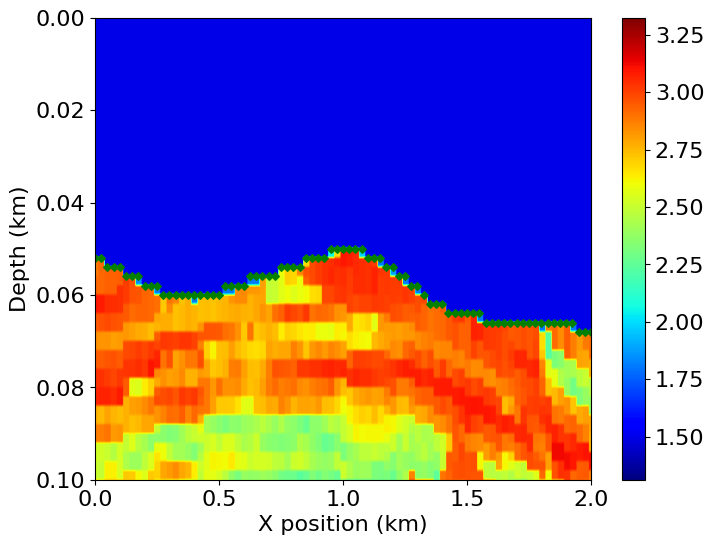

In [18]:
plot_rec_src(model=model, data_type='vp', src_coords=src.coordinates.data, rec_coords=rec.coordinates.data, xrange=(0,2), yrange=(0.1,0))

In [19]:
op(dt=dt)

Operator `Kernel` ran in 27.68 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=27.37507900000037, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.09285399999998417, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.09221699999997786, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

# Запись в файл

In [20]:
segy_file = segyio.tools.from_array2D('Results/test.sgy', rec.data.T, dt=dt*10**3)

/home/spaceswimmer/Documents/NeoGen_Modeling/.venv/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)


In [21]:
with segyio.open('Results/test.sgy', 'r+') as f:
    print(f.header[318])

{TRACE_SEQUENCE_LINE: 0, TRACE_SEQUENCE_FILE: 0, FieldRecord: 0, TraceNumber: 318, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 318, TraceIdentificationCode: 0, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: 1, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 0, SourceGroupScalar: 0, SourceX: 0, SourceY: 0, GroupX: 0, GroupY: 0, CoordinateUnits: 0, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 12093, TRACE_SAMPLE_INTERVAL: 165, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 0, SweepTraceTaperLengthStart: 0, SweepTraceTaperLengt

In [11]:
inheader = segysak.segy.segy_header_scrape(scenarios[1]+'/Vs 2D 1.sgy')

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

In [23]:
with segyio.open('Results/test.sgy', 'r+') as f:
    for j in range(len(f.header)):
        f.header[j] = {TraceField.CDP: j,
                       TraceField.CDP_X: np.array(inheader['CDP_X'][j]),
                       TraceField.CDP_Y: np.array(inheader['CDP_Y'][j]),
                       TraceField.ReceiverGroupElevation: np.array(df_ins['Z'][j], dtype = int),
                       TraceField.ElevationScalar : np.array(inheader['ElevationScalar'][j],
                       TraceField.SourceGroupScalar : np.array(inheader['ElevationScalar'][j],
                      }

In [13]:
inheader['SourceGroupScalar']

0     -10
1     -10
2     -10
3     -10
4     -10
       ..
314   -10
315   -10
316   -10
317   -10
318   -10
Name: SourceGroupScalar, Length: 319, dtype: int8

In [25]:
# with segyio.open('Results/test.sgy', mode = 'r+') as file:
#     vmin, vmax = -0.0001, 0.0001
#     figsize=(10,20)
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k', squeeze=True, sharex=True)
#     im = ax.imshow(file.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect = 'auto')

# Сейсмограммы

In [27]:
rec_max = rec.data.max(axis=0)
rec_max[rec_max == 0] = 1
rec_trace_norm = rec.data / rec_max

In [28]:
np.unique(rec.data[:, 1])

Data([-2.6337991e-06, -2.6335190e-06, -2.6322152e-06, ...,  2.8077702e-06,
       2.8105731e-06,  2.8109546e-06], dtype=float32)

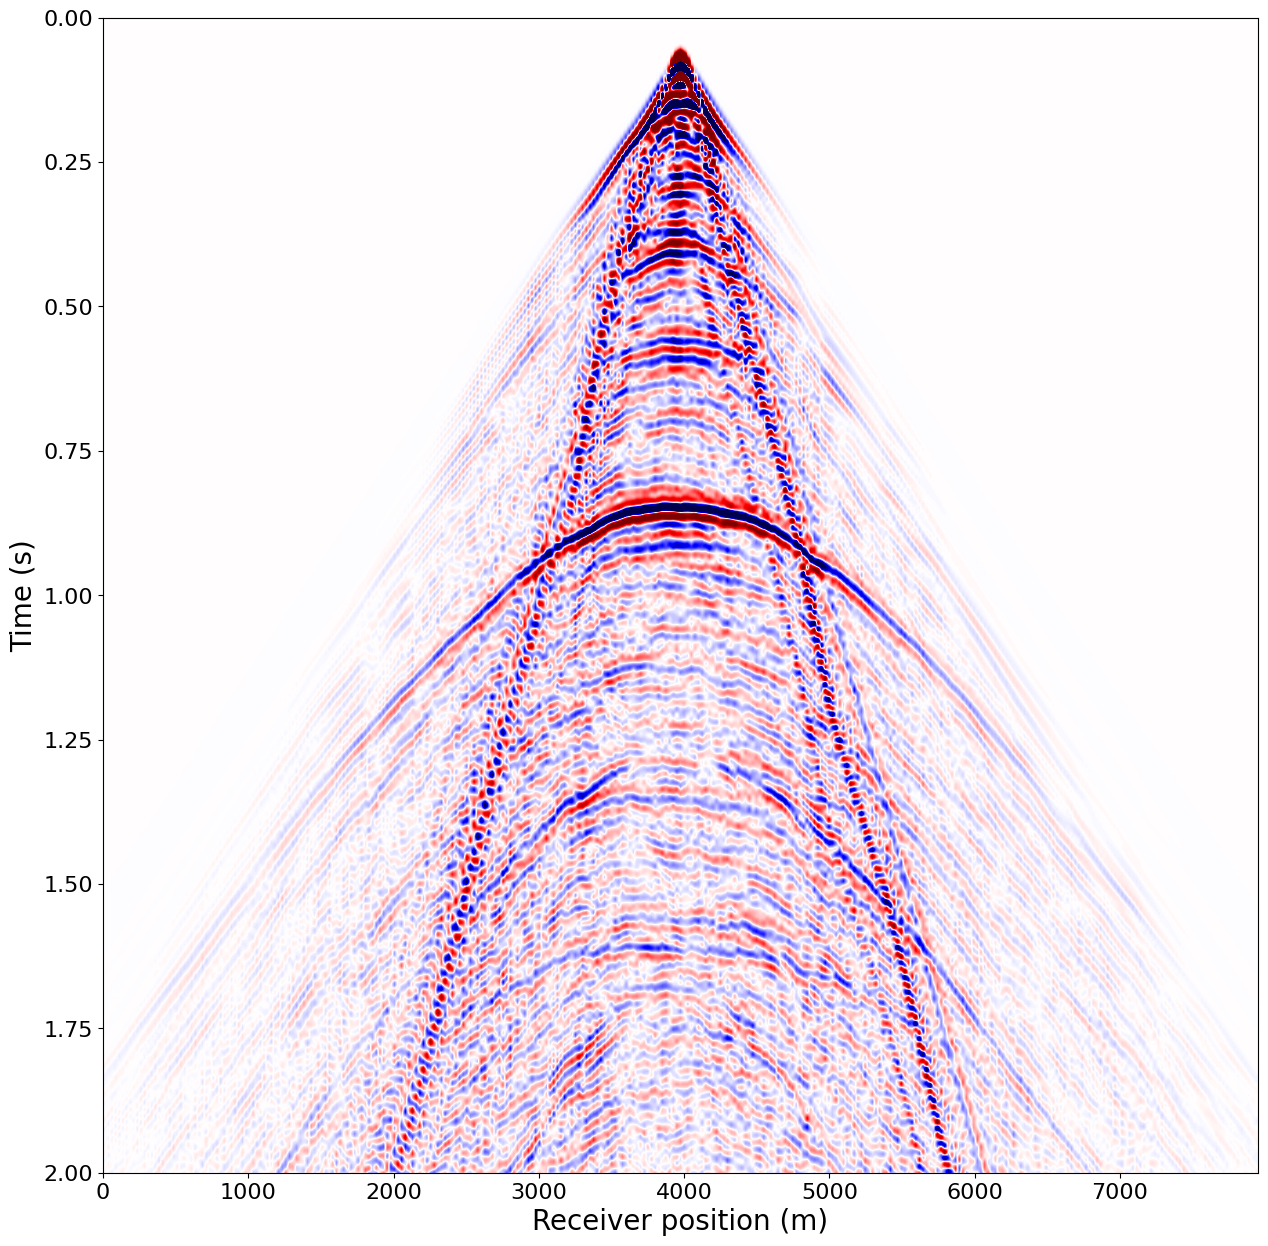

In [29]:
#NBVAL_SKIP
# Pressure (txx + tzz) data at sea surface
extent = [rec.coordinates.data[0, 0], rec.coordinates.data[-1, 0], 1e-3*tn, t0]
aspect = rec.coordinates.data[-1, 0]/(1e-3*tn)
vminmax = np.max(np.abs(rec.data))
gain = 2e1
sc = vminmax/gain
plt.figure(figsize=(15, 15))
plt.imshow(rec.data[::5,:], vmin=-sc, vmax=sc, cmap="seismic",
           interpolation='bilinear', extent=extent, aspect=aspect)
plt.ylabel("Time (s)", fontsize=20)
plt.xlabel("Receiver position (m)", fontsize=20)
plt.show()

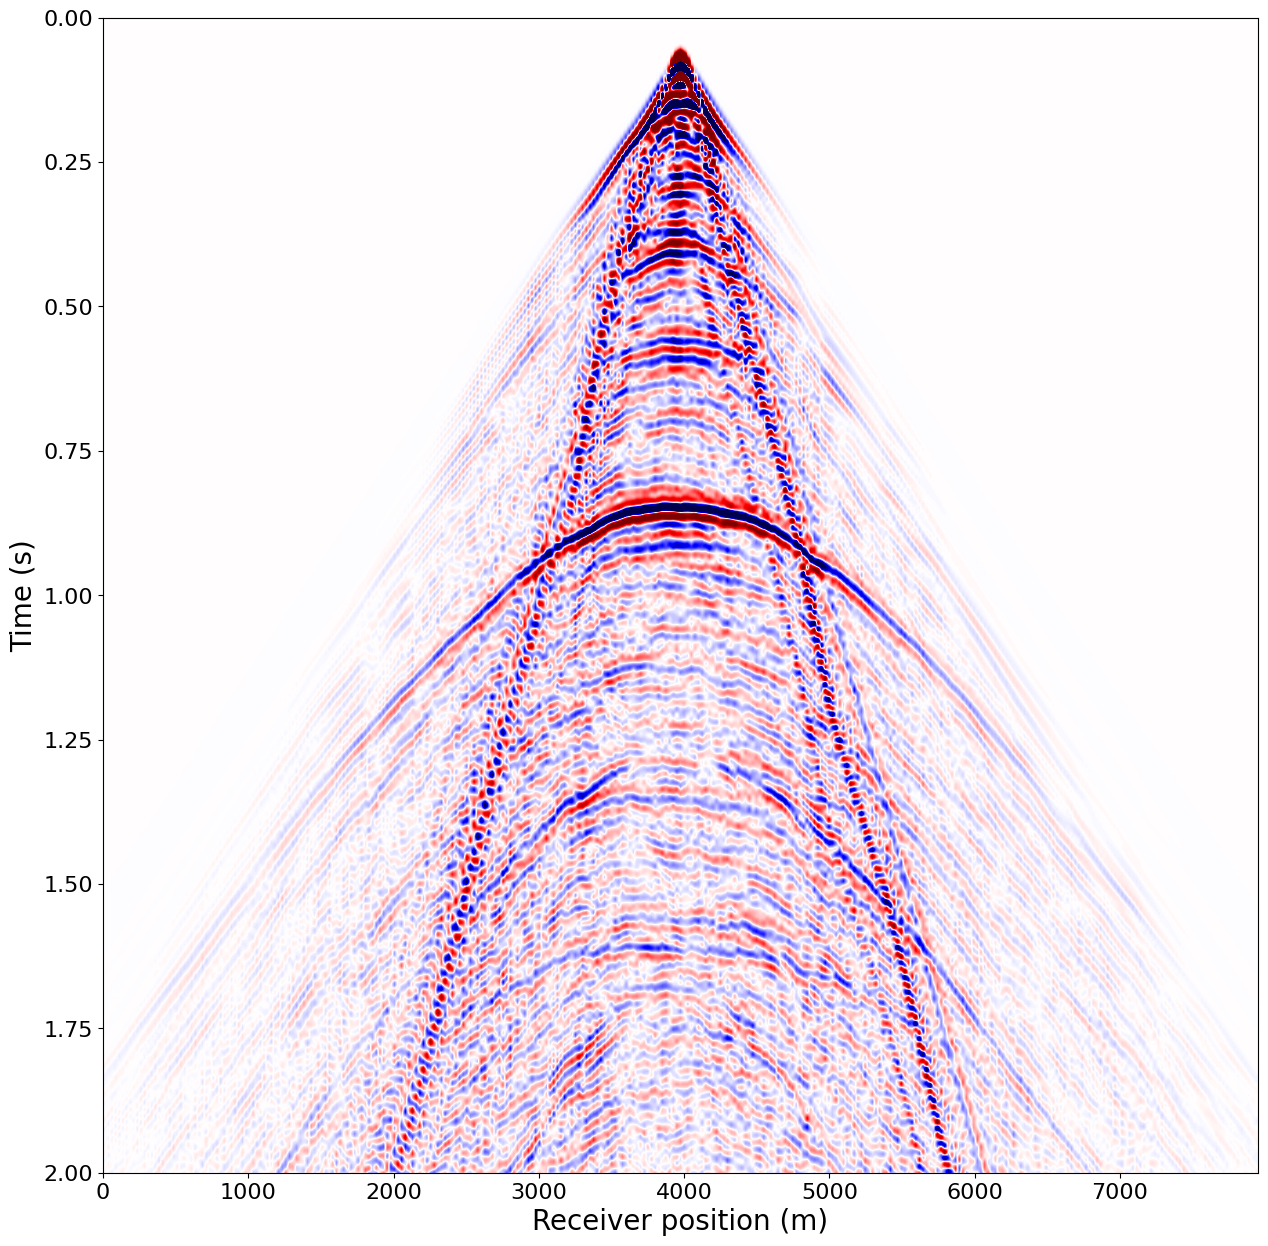

In [30]:
plot_seis_data(rec_coordinates=rec.coordinates.data,rec_data=rec.data, t0=t0, tn=tn)